### Attempting to run regressions from systematics values extracted geometrically or from Kitanidis et al on galaxy density


In [77]:
import pandas as pd
import numpy as np
import pickle
import healpy as hp
import statsmodels.api as sm
import matplotlib.pyplot as plt


In [78]:
### Setting Healpy Information
NSIDE = 256
NPIX = hp.nside2npix(NSIDE)
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)

def raDec2thetaPhi(ra, dec):
    return (0.5 * np.pi - np.deg2rad(dec)), (np.deg2rad(ra))


Approximate resolution at NSIDE 256 is 0.23 deg


### Importing Galaxy Density Information

In [79]:
df_objects = pd.read_csv('../bricks_data/galaxy_catalogue.csv')


In [80]:
df_objects = df_objects.drop_duplicates()

df_objects.head()

,BrickID,RA,DEC,Target_type,Fitbits,Maskbits
0,120312,5.165116,-39.411469,2,1,0
1,120312,5.165771,-39.443575,3,1,0
2,120312,5.167412,-39.552630,2,1,0
3,120312,5.169102,-39.400914,3,1,0
4,120312,5.169548,-39.533226,3,1,0


In [81]:
# LRG

df_LRG = df_objects[df_objects["Target_type"] == 1]
ra_LRG = df_LRG["RA"].to_numpy(copy=True)
dec_LRG = df_LRG["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_LRG, dec_LRG)

print("Number of LRGs in Sample:", len(ra_LRG))

LRG_pixel_indices = hp.ang2pix(NSIDE, theta,phi)


# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(LRG_pixel_indices, return_counts=True)

print(unique)

mean_LRG = counts.mean()
print("Mean LRGs per Pixel:", mean_LRG)
# Calculating Densities for every block

#density_LRG = (counts / mean_LRG) - 1
id_density = np.stack((unique, counts), axis=1)
#print(id_density)
df_lrg = pd.DataFrame(id_density, columns=['pixel_id', 'lrg'])
df_lrg.pixel_id = df_lrg.pixel_id.astype(int)
df_lrg.head()

Number of LRGs in Sample: 4271038
[  1564   1574   1577 ... 757955 758427 758428]
Mean LRGs per Pixel: 14.987518115751318


,pixel_id,lrg
0,1564,2
1,1574,4
2,1577,1
3,1668,3
4,1669,2


In [82]:
# elg

df_ELG = df_objects[df_objects["Target_type"] == 2]
ra_ELG = df_ELG["RA"].to_numpy(copy=True)
dec_ELG = df_ELG["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_ELG, dec_ELG)

print("Number of ELGs in Sample:", len(ra_ELG))

ELG_pixel_indices = hp.ang2pix(NSIDE, theta,phi)


# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(ELG_pixel_indices, return_counts=True)

print(unique)

mean_ELG = counts.mean()
print("Mean ELGs per Pixel:", mean_ELG)
# Calculating Densities for every block
#density_ELG = (counts / mean_ELG) - 1
id_density = np.stack((unique, counts), axis=1)
print(id_density)
df_elg = pd.DataFrame(id_density, columns=['pixel_id', 'elg'])
df_elg.pixel_id = df_elg.pixel_id.astype(int)

print(df_elg.head())

Number of ELGs in Sample: 14963034
[  1564   1574   1577 ... 758427 758428 758430]
Mean ELGs per Pixel: 49.39322037255271
[[  1564      4]
 [  1574      2]
 [  1577      7]
 ...
 [758427      6]
 [758428     11]
 [758430      6]]
   pixel_id  elg
0      1564    4
1      1574    2
2      1577    7
3      1668   13
4      1669   16


In [83]:
df_QSO = df_objects[df_objects["Target_type"] == 3]
ra_QSO = df_QSO["RA"].to_numpy(copy=True)
dec_QSO = df_QSO["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_QSO, dec_QSO)

print("Number of QSOs in Sample:", len(ra_QSO))

QSO_pixel_indices = hp.ang2pix(NSIDE, theta,phi)


# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(QSO_pixel_indices, return_counts=True)

print(unique)

mean_QSO = counts.mean()
print("Mean QSOs per Pixel:", mean_QSO)
# Calculating Densities for every block
#density_QSO = (counts / mean_QSO) - 1
id_density = np.stack((unique, counts), axis=1)
print(id_density)
df_qso = pd.DataFrame(id_density, columns=['pixel_id', 'qso'])
df_qso.pixel_id = df_qso.pixel_id.astype(int)

print(df_qso.head())

Number of QSOs in Sample: 20596063
[  1562   1563   1564 ... 758427 758428 758430]
Mean QSOs per Pixel: 67.3102550108338
[[  1562      2]
 [  1563      4]
 [  1564      8]
 ...
 [758427      8]
 [758428      6]
 [758430      4]]
   pixel_id  qso
0      1562    2
1      1563    4
2      1564    8
3      1574    6
4      1577    7


In [84]:
df = pd.merge(df_lrg, df_elg, how='outer', on='pixel_id')
df = pd.merge(df, df_qso, how='outer', on='pixel_id')
print(df.isna().sum())
print(df_lrg.shape, df_elg.shape, df_qso.shape, df.shape)

pixel_id        0
lrg         24826
elg          6862
qso          3812
dtype: int64
(284973, 2) (302937, 2) (305987, 2) (309799, 4)


In [85]:
# Dropping all pixels where I do not have counts for all 3 types of galaxies
df.dropna(axis=0, inplace=True)
print(df.isna().sum())

pixel_id    0
lrg         0
elg         0
qso         0
dtype: int64


In [86]:
print( df.shape)


(282196, 4)


### Importing the Systematics Values and Appending them to the df.


#### Stellar Density

In [87]:
df_stellar = pd.read_csv('../bricks_data/stellar_catalogue.csv')
df_stellar.shape


(4524152, 5)

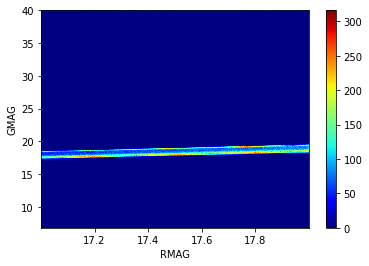

In [88]:
label_1 = 'RMAG'
label_2 = 'GMAG'

plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()

In [89]:
# REMOVING OUTLIERS
print(df_stellar.shape)

(4524152, 5)


In [90]:
df_stellar['GMR'] = df_stellar['GMAG'] - df_stellar['RMAG']
df_stellar['RMZ'] = df_stellar['RMAG'] - df_stellar['ZMAG']

In [91]:
df_stellar = df_stellar[(df_stellar['GMAG'] > 15) & (df_stellar['GMAG'] < 30) ]
df_stellar = df_stellar[(df_stellar['ZMAG'] > 15) & (df_stellar['ZMAG'] < 30) ]
df_stellar = df_stellar[(df_stellar['GMR'] > -2) & (df_stellar['GMR'] < 4) ]
df_stellar = df_stellar[(df_stellar['RMZ'] > -2) & (df_stellar['RMZ'] < 4) ]
print(df_stellar.shape)


(4357535, 7)


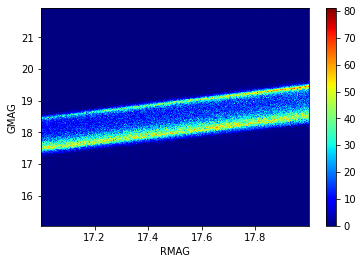

In [92]:
plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()

In [93]:
#Dividing RMAG Column into 100 equally filled bins (assuming within the RMAG of 17-18 this is somewhat uniform)
df_stellar['percent_RMAG'] = pd.qcut(df_stellar['RMAG'], q=1000, labels=False)
df_stellar['percent_RMAG'].value_counts()


573    4373
316    4373
759    4373
394    4372
507    4372
       ... 
754    4342
760    4342
368    4342
351    4342
653    4341
Name: percent_RMAG, Length: 1000, dtype: int64

In [94]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_RMAG')
zscore = lambda x: abs((x - x.median()) / x.std())
df_stellar['Z_SCORE_RMZ'] = grouped['RMZ'].transform(zscore)
df_stellar['Z_SCORE_GMR'] = grouped['GMR'].transform(zscore)

In [95]:
#Dividing RMAG Column into 100 equally filled bins (assuming within the RMAG of 17-18 this is somewhat uniform)
df_stellar['percent_GMR'] = pd.qcut(df_stellar['GMR'], q=1000, labels=False)
df_stellar['percent_RMZ'] = pd.qcut(df_stellar['RMZ'], q=1000, labels=False)
df_stellar.shape

(4357535, 12)

In [96]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_GMR')
df_stellar['Z_SCORE_RMZ'] = grouped['RMZ'].transform(zscore)


In [97]:
#grouped = df.groupby('percent_RMAG', as_index=False).sem()
grouped = df_stellar.groupby('percent_RMZ')
df_stellar['Z_SCORE_GMR'] = grouped['GMR'].transform(zscore)

In [98]:
print(df_stellar.shape)
df_stellar = df_stellar[(df_stellar['Z_SCORE_GMR'] < 3)]
print(df_stellar.shape)
df_stellar = df_stellar[(df_stellar['Z_SCORE_RMZ'] < 3)]
df_stellar.shape

(4357535, 12)
(4325356, 12)


(4306587, 12)

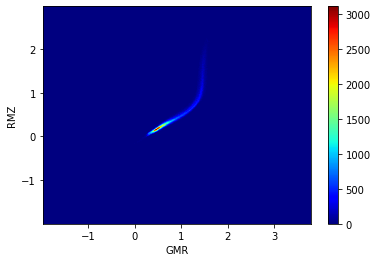

In [99]:
label_1 = 'GMR'
label_2 = 'RMZ'

plt.hist2d(df_stellar[label_1], df_stellar[label_2], bins=1000, cmap='jet')
plt.xlabel(label_1)
plt.ylabel(label_2)
plt.colorbar()
plt.show()

In [100]:
ra_stellar = df_stellar["RA"].to_numpy(copy=True)
dec_stellar = df_stellar["DEC"].to_numpy(copy=True)
theta, phi = raDec2thetaPhi(ra_stellar, dec_stellar)

print("Number of stellars in Sample:", len(ra_stellar))

stellar_pixel_indices = hp.ang2pix(NSIDE, theta,phi)


# Finding out unique indices and how often they appear --> shows the density of LRGs in this pixel
(unique, counts) = np.unique(stellar_pixel_indices, return_counts=True)

print(unique)

mean_stellar = counts.mean()
print("Mean stellars per Pixel:", mean_stellar)
# Calculating Densities for every block
density_stellar = (counts / mean_stellar) - 1
id_density = np.stack((unique, counts), axis=1)
print(id_density)
df_stellar = pd.DataFrame(id_density, columns=['pixel_id', 'stellar'])
df_stellar.pixel_id = df_stellar.pixel_id.astype(int)

print(df_stellar.head())

print(df_stellar.isna().sum())

Number of stellars in Sample: 4306587
[  1562   1574   1577 ... 757954 757955 758427]
Mean stellars per Pixel: 15.356262368735402
[[  1562      1]
 [  1574      3]
 [  1577      1]
 ...
 [757954      7]
 [757955      4]
 [758427      2]]
   pixel_id  stellar
0      1562        1
1      1574        3
2      1577        1
3      1673        4
4      1675       13
pixel_id    0
stellar     0
dtype: int64


In [101]:
df = df.merge(df_stellar, how='inner', on='pixel_id')
print(df.isna().sum())
df.shape

pixel_id    0
lrg         0
elg         0
qso         0
stellar     0
dtype: int64


(268108, 5)

#### EBV Extraction

In [102]:
from astropy.coordinates import SkyCoord, Latitude, Longitude
from dustmaps.sfd import SFDQuery


In [103]:
## Getting the centers of each pixel in my corpus as RaDec

pixels_ids = df["pixel_id"].to_numpy()
print(pixels_ids)
subpixel_coords = hp.pix2ang(NSIDE,pixels_ids, lonlat=True)
ra_ebv= subpixel_coords[0]
dec_ebv = subpixel_coords[1]

[  1574   1577   1673 ... 757954 757955 758427]


In [104]:
#Querying their position on the SFD dustmap
sfd = SFDQuery()
coords = SkyCoord(ra_ebv, dec_ebv, frame='icrs', unit='deg')
ebv = sfd(coords)

df["EBV"] = ebv

In [105]:
df.EBV.describe()
df.head()

,pixel_id,lrg,elg,qso,stellar,EBV
0,1574,4.0,2.0,6.0,3,0.135581
1,1577,1.0,7.0,7.0,1,0.090038
2,1673,1.0,8.0,22.0,4,0.150272
3,1675,21.0,45.0,84.0,13,0.231753
4,1676,1.0,10.0,14.0,4,0.233339


In [106]:
df.lrg = df.lrg.astype(int)
df.elg = df.elg.astype(int)
df.qso = df.qso.astype(int)
df.dtypes

pixel_id      int64
lrg           int64
elg           int64
qso           int64
stellar       int64
EBV         float32
dtype: object

#### Kitanidis Systematics Values

In [107]:
with open('../bricks_data/pixel2systematics_kitanidis.pickle', 'rb') as f:
    kitanidis_dict = pickle.load(f)
    f.close()

print(len(kitanidis_dict.keys()))

165618


In [108]:
pixel_keys = kitanidis_dict.keys()

sys_list = []
for key in pixel_keys:
    ind_sys_list = kitanidis_dict[key]
    ind_sys_list.append(key)
    sys_list.append(ind_sys_list)

df_sys_kit = pd.DataFrame(sys_list, columns=['airmass',
'fwhm',
'ccdskysb_g',
'ccdskysb_r',
'ccdskysb_z',
'exptime_g',
'exptime_r',
'exptime_z',
'meansky_g',
'meansky_r',
'meansky_z',
'galdepth_g',
'galdepth_r',
'galdepth_z', 'pixel_id'])


In [109]:
# Remove columns where values are zero
df_sys_kit.describe()

print(df_sys_kit.shape)
df_sys_kit = df_sys_kit.drop(index=[99852,111780])
print(df_sys_kit.shape)

(165618, 15)
(165616, 15)


In [110]:
df_kitanidis = df.merge(df_sys_kit, how='inner', on='pixel_id')
print(df_kitanidis.isna().sum())
df_kitanidis.dropna(axis=0, inplace=True)

df_kitanidis.head()


pixel_id       0
lrg            0
elg            0
qso            0
stellar        0
EBV            0
airmass        0
fwhm           0
ccdskysb_g    44
ccdskysb_r    31
ccdskysb_z     6
exptime_g      0
exptime_r      0
exptime_z      0
meansky_g      0
meansky_r      0
meansky_z      0
galdepth_g     0
galdepth_r     0
galdepth_z     0
dtype: int64


,pixel_id,lrg,elg,qso,stellar,EBV,airmass,fwhm,ccdskysb_g,ccdskysb_r,ccdskysb_z,exptime_g,exptime_r,exptime_z,meansky_g,meansky_r,meansky_z,galdepth_g,galdepth_r,galdepth_z
0,1675,21,45,84,13,0.231753,1.718913,4.012114,22.476277,21.391496,19.028658,206.4,238.800000,204.665230,0.311778,5.562486,2.361189,22.510944,22.103737,22.434057
1,1677,16,44,82,8,0.198980,1.718603,4.402495,23.463299,21.424381,19.190657,180.0,230.000000,186.239429,0.291843,3.932022,2.004705,23.508274,22.167623,22.452290
2,1678,22,45,94,14,0.178034,1.712459,4.023360,22.447087,21.395767,19.164751,207.8,238.690000,200.886003,0.294317,4.624029,2.046824,22.614710,22.139793,22.452860
3,1689,16,34,71,13,0.131707,1.735196,4.390453,23.346248,22.741932,18.669951,250.0,173.886980,204.784836,0.311296,0.720955,3.505871,23.638793,23.095866,22.145799
4,1691,23,49,85,20,0.101732,1.766976,4.470975,23.345020,22.752506,18.589021,250.0,172.070999,216.971573,0.310873,0.713051,5.224869,23.662212,23.019058,22.088499


In [111]:
print(df_kitanidis.isna().sum())


pixel_id      0
lrg           0
elg           0
qso           0
stellar       0
EBV           0
airmass       0
fwhm          0
ccdskysb_g    0
ccdskysb_r    0
ccdskysb_z    0
exptime_g     0
exptime_r     0
exptime_z     0
meansky_g     0
meansky_r     0
meansky_z     0
galdepth_g    0
galdepth_r    0
galdepth_z    0
dtype: int64


#### Geometric Systematics Values, not involving edge pixels

In [119]:
with open('../bricks_data/pixel2systematics_geometric_non_inclusive.pickle', 'rb') as f:
    geometric_dict_no = pickle.load(f)
    f.close()

print(len(geometric_dict_no.keys()))

446042
446042


In [120]:
sys_list = []
for key in geometric_dict_no.keys():
    ind_sys_list = geometric_dict_no[key]
    ind_sys_list.append(key)
    sys_list.append(ind_sys_list)

df_sys_geo_no = pd.DataFrame(sys_list, columns=['airmass',
'fwhm',
'ccdskysb_g',
'ccdskysb_r',
'ccdskysb_z',
'exptime_g',
'exptime_r',
'exptime_z',
'meansky_g',
'meansky_r',
'meansky_z',
'galdepth_g',
'galdepth_r',
'galdepth_z', 'pixel_id'])


In [121]:
df_geometric_no = df.merge(df_sys_geo_no, how='inner', on='pixel_id')
print(df_geometric_no.isna().sum())
df_geometric_no.dropna(axis=0, inplace=True)
print(df_geometric_no.isna().sum())

pixel_id       0
lrg            0
elg            0
qso            0
stellar        0
EBV            0
airmass        0
fwhm           0
ccdskysb_g    38
ccdskysb_r    29
ccdskysb_z     2
exptime_g      0
exptime_r      0
exptime_z      0
meansky_g      0
meansky_r      0
meansky_z      0
galdepth_g     0
galdepth_r     0
galdepth_z     0
dtype: int64
pixel_id      0
lrg           0
elg           0
qso           0
stellar       0
EBV           0
airmass       0
fwhm          0
ccdskysb_g    0
ccdskysb_r    0
ccdskysb_z    0
exptime_g     0
exptime_r     0
exptime_z     0
meansky_g     0
meansky_r     0
meansky_z     0
galdepth_g    0
galdepth_r    0
galdepth_z    0
dtype: int64


In [129]:
#df_geometric_no.drop(columns=['pixel_id'], inplace=True)
#df_geometric_no.to_csv('../bricks_data/dataset_geometric.csv', index=False)

In [124]:
print(df_geometric_no.describe())

            pixel_id            lrg            elg            qso  \
count  267226.000000  267226.000000  267226.000000  267226.000000   
mean   346071.952115      15.794111      55.094819      75.864770   
std    202938.283807      12.368389      37.172325      50.538023   
min      1673.000000       1.000000       1.000000       1.000000   
25%    190644.250000       6.000000      23.000000      32.000000   
50%    327698.000000      14.000000      51.000000      70.000000   
75%    472447.500000      23.000000      83.000000     113.000000   
max    757954.000000     529.000000    1840.000000    1266.000000   

             stellar            EBV        airmass           fwhm  \
count  267226.000000  267226.000000  267226.000000  267226.000000   
mean       15.955191       0.042766       1.363079       4.412227   
std        18.903334       0.032873       0.255462       0.977313   
min         1.000000       0.000583       1.000179       2.570826   
25%         5.000000       0.0202

In [129]:
df_geometric = df_geometric_no.drop(index=[38700])

In [130]:
print(df_kitanidis.shape)
print(df_geometric.shape)


(165437, 20)
(267225, 20)


### Running the Regressions

#### 1. Kitanidis

In [131]:
df_kitanidis.head()
df_kitanidis_reg = df_kitanidis.drop(columns=['pixel_id'])
df_kitanidis_reg.head()

,lrg,elg,qso,stellar,EBV,airmass,fwhm,ccdskysb_g,ccdskysb_r,ccdskysb_z,exptime_g,exptime_r,exptime_z,meansky_g,meansky_r,meansky_z,galdepth_g,galdepth_r,galdepth_z
0,21,45,84,13,0.231753,1.718913,4.012114,22.476277,21.391496,19.028658,206.4,238.800000,204.665230,0.311778,5.562486,2.361189,22.510944,22.103737,22.434057
1,16,44,82,8,0.198980,1.718603,4.402495,23.463299,21.424381,19.190657,180.0,230.000000,186.239429,0.291843,3.932022,2.004705,23.508274,22.167623,22.452290
2,22,45,94,14,0.178034,1.712459,4.023360,22.447087,21.395767,19.164751,207.8,238.690000,200.886003,0.294317,4.624029,2.046824,22.614710,22.139793,22.452860
3,16,34,71,13,0.131707,1.735196,4.390453,23.346248,22.741932,18.669951,250.0,173.886980,204.784836,0.311296,0.720955,3.505871,23.638793,23.095866,22.145799
4,23,49,85,20,0.101732,1.766976,4.470975,23.345020,22.752506,18.589021,250.0,172.070999,216.971573,0.310873,0.713051,5.224869,23.662212,23.019058,22.088499


In [133]:
y_lrg = df_kitanidis_reg['lrg']#.to_numpy(copy=True)
y_elg = df_kitanidis_reg['elg']#.to_numpy(copy=True)
y_qso = df_kitanidis_reg['qso']#.to_numpy(copy=True)

X = df_kitanidis_reg.drop(columns=['lrg','elg','qso'])#.to_numpy(copy=True)

In [134]:
print(len(y_lrg))
print(len(X))

165437
165437


In [135]:


ols_lrg_kitanidis = sm.OLS(y_lrg,X).fit()
print(ols_lrg_kitanidis.summary())

print()
ols_elg_kitanidis = sm.OLS(y_elg,X).fit()
print(ols_elg_kitanidis.summary())
print()
ols_qso_kitanidis = sm.OLS(y_qso,X).fit()
print(ols_qso_kitanidis.summary())

                            OLS Regression Results                            
Dep. Variable:                    lrg   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.072
Method:                 Least Squares   F-statistic:                     860.8
Date:                Thu, 01 Jul 2021   Prob (F-statistic):               0.00
Time:                        13:06:10   Log-Likelihood:            -6.3320e+05
No. Observations:              165437   AIC:                         1.266e+06
Df Residuals:                  165421   BIC:                         1.267e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
stellar        0.1556      0.001    109.468      0.0

#### 2. Geometric

In [137]:
df_geometric.head()
df_geometric_reg = df_geometric.drop(columns=['pixel_id'])
df_geometric_reg.head()

,lrg,elg,qso,stellar,EBV,airmass,fwhm,ccdskysb_g,ccdskysb_r,ccdskysb_z,exptime_g,exptime_r,exptime_z,meansky_g,meansky_r,meansky_z,galdepth_g,galdepth_r,galdepth_z
0,1,8,22,4,0.150272,1.755791,4.054279,23.362753,21.275543,18.728977,250.0,250.000000,178.104004,0.350981,7.418882,3.168162,23.455763,21.988368,22.284269
1,21,45,84,13,0.231753,1.752745,4.333361,23.412788,21.349841,18.934986,215.0,240.000000,160.604004,0.324769,5.615912,2.599613,23.448900,22.083221,22.318394
2,1,10,14,4,0.233339,1.752675,4.432289,23.463202,21.424571,19.099052,180.0,230.000000,171.106506,0.288073,3.914232,2.233619,23.412380,22.185323,22.341307
3,16,44,82,8,0.198980,1.743200,4.533583,23.463299,21.424380,19.140076,180.0,230.000000,176.439677,0.291843,3.932022,2.134053,23.508274,22.167623,22.373904
4,22,45,94,14,0.178034,1.725647,4.229492,23.385620,21.436897,19.110413,215.0,237.916667,213.606003,0.305991,4.657650,2.125587,23.555042,22.131536,22.489397


In [138]:
y_lrg = df_geometric_reg['lrg']#.to_numpy(copy=True)
y_elg = df_geometric_reg['elg']#.to_numpy(copy=True)
y_qso = df_geometric_reg['qso']#.to_numpy(copy=True)

X = df_geometric_reg.drop(columns=['lrg','elg','qso'])#.to_numpy(copy=True)

In [139]:
print(len(y_lrg))
print(len(X))

267225
267225


In [140]:
ols_lrg_geometric = sm.OLS(y_lrg,X).fit()
print(ols_lrg_geometric.summary())
print()
ols_elg_geometric = sm.OLS(y_elg,X).fit()
print(ols_elg_geometric.summary())
print()
ols_qso_geometric = sm.OLS(y_qso,X).fit()
print(ols_qso_geometric.summary())


                            OLS Regression Results                            
Dep. Variable:                    lrg   R-squared:                       0.221
Model:                            OLS   Adj. R-squared:                  0.221
Method:                 Least Squares   F-statistic:                     5062.
Date:                Thu, 01 Jul 2021   Prob (F-statistic):               0.00
Time:                        13:07:28   Log-Likelihood:            -1.0179e+06
No. Observations:              267225   AIC:                         2.036e+06
Df Residuals:                  267209   BIC:                         2.036e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
stellar        0.3239      0.001    273.615      0.0

## Plotting the different systematics maps



In [141]:
print(df_kitanidis.shape)
print(df_geometric.shape)




(165437, 20)
(267225, 20)


In [181]:
print(len(df_geometric.pixel_id.unique()))

268046


In [142]:
df_geo_temp = df_geometric(
df_all = df_kitanidis.merge(df_geometric, how='inner', on='pixel_id', suffixes=('_kitanidis', '_geometric'))
df_all.drop(columns=['lrg','elg','qso', 'airmass', 'EBV']))

,pixel_id,lrg_kitanidis,elg_kitanidis,qso_kitanidis,stellar_kitanidis,EBV_kitanidis,airmass_kitanidis,fwhm_kitanidis,ccdskysb_g_kitanidis,ccdskysb_r_kitanidis,...,ccdskysb_z_geometric,exptime_g_geometric,exptime_r_geometric,exptime_z_geometric,meansky_g_geometric,meansky_r_geometric,meansky_z_geometric,galdepth_g_geometric,galdepth_r_geometric,galdepth_z_geometric
0,1675,21,45,84,13,0.231753,1.718913,4.012114,22.476277,21.391496,...,18.934986,215.0,240.000000,160.604004,0.324769,5.615912,2.599613,23.448900,22.083221,22.318394
1,1677,16,44,82,8,0.198980,1.718603,4.402495,23.463299,21.424381,...,19.140076,180.0,230.000000,176.439677,0.291843,3.932022,2.134053,23.508274,22.167623,22.373904
2,1678,22,45,94,14,0.178034,1.712459,4.023360,22.447087,21.395767,...,19.110413,215.0,237.916667,213.606003,0.305991,4.657650,2.125587,23.555042,22.131536,22.489397
3,1689,16,34,71,13,0.131707,1.735196,4.390453,23.346248,22.741932,...,18.603508,250.0,173.535492,160.437988,0.310965,0.719607,3.963446,23.634092,23.083635,22.012065
4,1691,23,49,85,20,0.101732,1.766976,4.470975,23.345020,22.752506,...,18.406242,250.0,172.070999,220.105011,0.310873,0.713051,5.868712,23.662212,23.019058,21.914766


In [188]:
df_all.columns

Index(['pixel_id', 'lrg_density_x', 'elg_density_x', 'qso_density_x',
       'stellar_density_x', 'airmass_galaxy_x', 'fwhm_galaxy_x',
       'ebv_galaxy_x', 'ccdnphotom_galaxy_x', 'ccdskysb_galaxy_g_x',
       'ccdskysb_galaxy_r_x', 'ccdskysb_galaxy_z_x', 'exptime_galaxy_g_x',
       'exptime_galaxy_r_x', 'exptime_galaxy_z_x', 'meansky_galaxy_g_x',
       'meansky_galaxy_r_x', 'meansky_galaxy_z_x', 'galdepth_galaxy_g_x',
       'galdepth_galaxy_r_x', 'galdepth_galaxy_z_x', 'lrg_density_y',
       'elg_density_y', 'qso_density_y', 'stellar_density_y',
       'airmass_galaxy_y', 'fwhm_galaxy_y', 'ebv_galaxy_y',
       'ccdnphotom_galaxy_y', 'ccdskysb_galaxy_g_y', 'ccdskysb_galaxy_r_y',
       'ccdskysb_galaxy_z_y', 'exptime_galaxy_g_y', 'exptime_galaxy_r_y',
       'exptime_galaxy_z_y', 'meansky_galaxy_g_y', 'meansky_galaxy_r_y',
       'meansky_galaxy_z_y', 'galdepth_galaxy_g_y', 'galdepth_galaxy_r_y',
       'galdepth_galaxy_z_y'],
      dtype='object')

In [193]:
df_all['LRG_diff'] = df_all['stellar_density_x'] - df_all['stellar_density_y']

0.0 180.0 -180.0 180.0


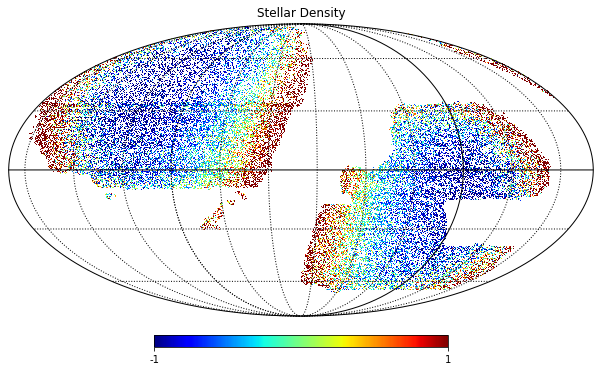

In [207]:
m = np.zeros(NPIX)

m[df_all.pixel_id.unique()] = df_all.stellar_density_x.to_numpy()

mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title="Stellar Density", min=-1, max=1,cmap="jet", notext=False, rot=(100,0,0), badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()

0.0 180.0 -180.0 180.0


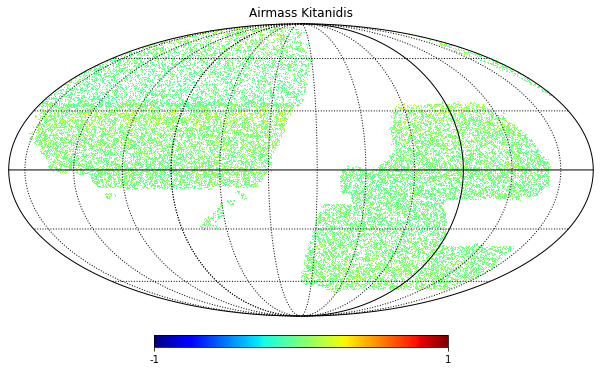

In [209]:
m = np.zeros(NPIX)

m[df_all.pixel_id.unique()] = df_all.airmass_galaxy_x.to_numpy()

mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title="Airmass Kitanidis", min=-1, max=1,cmap="jet", notext=False, rot=(100,0,0), badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()

0.0 180.0 -180.0 180.0


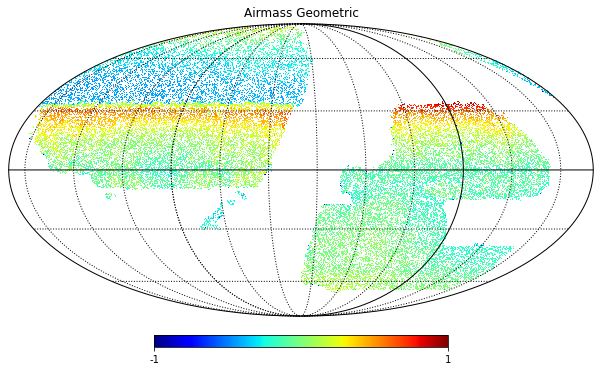

In [210]:
m = np.zeros(NPIX)

m[df_all.pixel_id.unique()] = df_all.airmass_galaxy_y.to_numpy()

mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title="Airmass Geometric", min=-1, max=1,cmap="jet", notext=False, rot=(100,0,0), badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()



0.0 180.0 -180.0 180.0


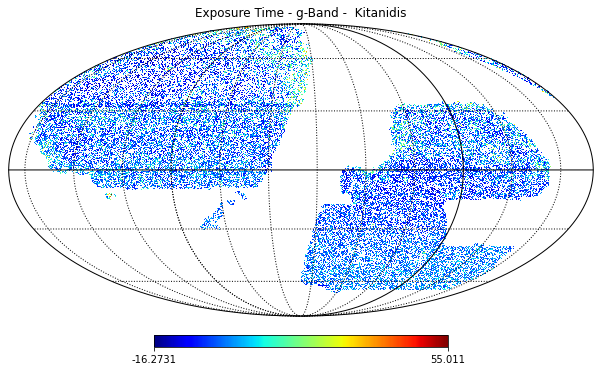

In [217]:
m = np.zeros(NPIX)

m[df_all.pixel_id.unique()] = df_all.exptime_galaxy_g_x.to_numpy()

mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title="Exposure Time - g-Band -  Kitanidis",cmap="jet", notext=False, rot=(100,0,0), badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()

0.0 180.0 -180.0 180.0


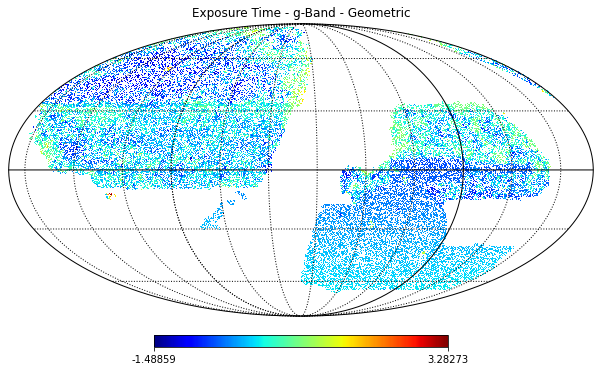

In [218]:
m = np.zeros(NPIX)

m[df_all.pixel_id.unique()] = df_all.exptime_galaxy_g_y.to_numpy()

mask = (m == 0)
m[mask] = np.nan
hp.mollview(m, title="Exposure Time - g-Band - Geometric",cmap="jet", notext=False, rot=(100,0,0), badcolor='white', remove_dip=True, remove_mono=True)
hp.graticule()

In [221]:
for column in df_kitanidis.columns:
    print("Systematic:", column)
    print()
    print("Kitanidis")
    print("Mean", df_kitanidis[column].mean())
    print("Median", df_kitanidis[column].mean())
    print("STD",df_kitanidis[column].std())
    print("MIN",df_kitanidis[column].min())
    print("MAX",df_kitanidis[column].max())
    print()
    print("Geometric")
    print("Mean", df_geometric_no[column].mean())
    print("Median", df_geometric_no[column].mean())
    print("STD",df_geometric_no[column].std())
    print("MIN",df_geometric_no[column].min())
    print("MAX",df_geometric_no[column].max())
    print()
    print("======================")
    print()


Systematic: pixel_id

Kitanidis
Mean 352465.4717989325
Median 352465.4717989325
STD 198996.29903906412
MIN 1675
MAX 757952

Geometric
Mean 346303.7437230923
Median 346303.7437230923
STD 202934.57124515375
MIN 1574
MAX 758427


Systematic: lrg_density

Kitanidis
Mean 0.4756671529494112
Median 0.4756671529494112
STD 0.7701868658172164
MIN -0.9332778120915806
MAX 34.29603740355389

Geometric
Mean 0.05241415831568339
Median 0.05241415831568339
STD 0.825291364266258
MIN -0.9332778120915806
MAX 34.29603740355389


Systematic: elg_density

Kitanidis
Mean 0.5658684364281835
Median 0.5658684364281835
STD 0.5954929524345455
MIN -0.8785258390778234
MAX 36.25207601613416

Geometric
Mean 0.1143583299637223
Median 0.1143583299637223
STD 0.7538950575062905
MIN -0.9797543065129706
MAX 36.25207601613416


Systematic: qso_density

Kitanidis
Mean 0.5825993626471587
Median 0.5825993626471587
STD 0.5847732439365153
MIN -0.9405736911952541
MAX 17.808426736702057

Geometric
Mean 0.12564320203969445
Median 0.

In [230]:
df_all.columns

Index(['pixel_id', 'lrg_density_x', 'elg_density_x', 'qso_density_x',
       'stellar_density_x', 'airmass_galaxy_x', 'fwhm_galaxy_x',
       'ebv_galaxy_x', 'ccdnphotom_galaxy_x', 'ccdskysb_galaxy_g_x',
       'ccdskysb_galaxy_r_x', 'ccdskysb_galaxy_z_x', 'exptime_galaxy_g_x',
       'exptime_galaxy_r_x', 'exptime_galaxy_z_x', 'meansky_galaxy_g_x',
       'meansky_galaxy_r_x', 'meansky_galaxy_z_x', 'galdepth_galaxy_g_x',
       'galdepth_galaxy_r_x', 'galdepth_galaxy_z_x', 'lrg_density_y',
       'elg_density_y', 'qso_density_y', 'stellar_density_y',
       'airmass_galaxy_y', 'fwhm_galaxy_y', 'ebv_galaxy_y',
       'ccdnphotom_galaxy_y', 'ccdskysb_galaxy_g_y', 'ccdskysb_galaxy_r_y',
       'ccdskysb_galaxy_z_y', 'exptime_galaxy_g_y', 'exptime_galaxy_r_y',
       'exptime_galaxy_z_y', 'meansky_galaxy_g_y', 'meansky_galaxy_r_y',
       'meansky_galaxy_z_y', 'galdepth_galaxy_g_y', 'galdepth_galaxy_r_y',
       'galdepth_galaxy_z_y', 'percentile_stellar_density', 'percentile'],
      dty

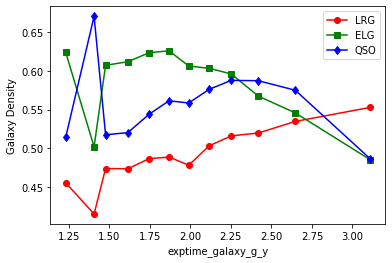

In [254]:
x_label = 'exptime_galaxy_g_y'

df_all['percentile'] = pd.qcut(df_all[x_label], q=15, labels=False, duplicates='drop')
grouped = df_all.groupby('percentile')
x = grouped[x_label].mean()
lrg = grouped['lrg_density_x'].mean()
elg = grouped['elg_density_x'].mean()
qso = grouped['qso_density_x'].mean()

plt.plot(x,lrg, c='red', marker='o', label="LRG")
plt.plot(x,elg, c='green', marker='s', label="ELG")
plt.plot(x,qso, c='blue', marker='d', label="QSO")

plt.xlabel(x_label)
plt.ylabel("Galaxy Density")
plt.legend()
plt.show()